# PAF Calculations with the Interactive Sim 

The PAFs I need are: 
- All Risks to HF 
- All Risks to IHD 
- All Risks to Stroke

In [1]:
from vivarium import InteractiveContext, Artifact

from datetime import datetime, timedelta
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd, numpy as np
pd.set_option('display.max_rows', 60)
import seaborn as sns

import numpy as np
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.backends.backend_pdf import PdfPages
import scipy.stats

### Create Interactive Sim

In [2]:
path = Path('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')

In [3]:
sim = InteractiveContext(Path(path), setup=False)
sim.configuration.update({
                          'population':
                              {'population_size': 10_000,
                              },
                          'time':
                              {'start':
                                  {'year': 2021
                                  }
                              }
                          }
                        )
sim.setup()

2023-02-15 11:04:45.875 | DEBUG    | vivarium.framework.values:register_value_modifier:392 - Registering metrics.1.population_manager.metrics as modifier to metrics
2023-02-15 11:04:46.004 | DEBUG    | vivarium.framework.artifact.manager:_load_artifact:66 - Running simulation from artifact located at /ihme/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf.
2023-02-15 11:04:46.006 | DEBUG    | vivarium.framework.artifact.manager:_load_artifact:67 - Artifact base filter terms are ['draw == 0'].
2023-02-15 11:04:46.010 | DEBUG    | vivarium.framework.artifact.manager:_load_artifact:68 - Artifact additional filter terms are None.
2023-02-15 11:04:46.370 | DEBUG    | vivarium.framework.values:_register_value_producer:338 - Registering value pipeline cause_specific_mortality_rate
2023-02-15 11:04:46.371 | DEBUG    | vivarium.framework.values:_register_value_producer:338 - Registering value pipeline mortality_rate
2023-02-15 11:04:46.704 | DEBUG    | vivarium.framework.values:_regis

In [4]:
pop0 = sim.get_population()
pop0.head()

,tracked,sex,entrance_time,location,alive,age,exit_time,cause_of_death,years_of_life_lost,years_lived_with_disability,...,ldlc_medication,ldlc_multiplier,sbp_multiplier,sbp_medication_adherence,polypill,ldlc_medication_adherence,sbp_medication,outreach,scheduled_date,visit_type
0,True,Female,2020-12-04,Alabama,alive,47.388882,NaT,not_dead,0.0,0.0,...,no_treatment,1.000,1.0,cat3,cat2,cat3,no_treatment,cat2,NaT,none
1,True,Male,2020-12-04,Alabama,alive,41.564194,NaT,not_dead,0.0,0.0,...,no_treatment,1.000,1.0,cat3,cat2,cat3,no_treatment,cat2,NaT,none
2,True,Female,2020-12-04,Alabama,alive,53.155826,NaT,not_dead,0.0,0.0,...,medium_intensity,1.362,1.0,cat1,cat2,cat3,one_drug_half_dose_efficacy,cat2,NaT,none
3,True,Male,2020-12-04,Alabama,alive,30.457692,NaT,not_dead,0.0,0.0,...,no_treatment,1.000,1.0,cat3,cat2,cat1,no_treatment,cat2,NaT,none
4,True,Female,2020-12-04,Alabama,alive,19.554806,NaT,not_dead,0.0,0.0,...,no_treatment,1.000,1.0,cat3,cat2,cat1,no_treatment,cat2,NaT,none


In [5]:
pop1 = pop0[['sex','alive','age']]

In [6]:
#pop0.columns

In [7]:
#sim.list_values()

In [8]:
data1 = pd.concat([pop1,
                   sim.get_value('high_body_mass_index_in_adults.propensity')(pop0.index).rename('bmi_propensity'),
                   sim.get_value('high_body_mass_index_in_adults.exposure')(pop0.index).rename('bmi_exposure'),
                   sim.get_value('high_ldl_cholesterol.propensity')(pop0.index).rename('ldl_propensity'),
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('ldl_exposure'),
                   sim.get_value('high_systolic_blood_pressure.propensity')(pop0.index).rename('sbp_propensity'),
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('sbp_exposure'),
                   sim.get_value('high_fasting_plasma_glucose.propensity')(pop0.index).rename('fpg_propensity'),
                   sim.get_value('high_fasting_plasma_glucose.exposure')(pop0.index).rename('fpg_exposure'),
                   sim.get_value('acute_myocardial_infarction.incidence_rate')(pop0.index).rename('mi_incidence'),
                   sim.get_value('acute_myocardial_infarction.incidence_rate.paf')(pop0.index).rename('mi_incidence_paf'),
                   sim.get_value('acute_ischemic_stroke.incidence_rate')(pop0.index).rename('stroke_incidence'),
                   sim.get_value('acute_ischemic_stroke.incidence_rate.paf')(pop0.index).rename('stroke_incidence_paf'),
                  ], axis=1)
data1.head()

,sex,alive,age,bmi_propensity,bmi_exposure,ldl_propensity,ldl_exposure,sbp_propensity,sbp_exposure,fpg_propensity,fpg_exposure,mi_incidence,mi_incidence_paf,stroke_incidence,stroke_incidence_paf
0,Female,alive,47.388882,0.208828,23.564850,0.362468,2.672922,0.650952,126.711324,0.839684,5.987195,0.000010,0.967287,0.000008,0.959927
1,Male,alive,41.564194,0.358604,25.661107,0.695510,3.377397,0.625507,135.497307,0.385293,5.480734,0.000028,0.983091,0.000008,0.969345
2,Female,alive,53.155826,0.531571,34.110372,0.155857,1.864838,0.165289,112.215005,0.891604,7.501187,0.000020,0.941682,0.000019,0.947248
3,Male,alive,30.457692,0.388049,26.473747,0.821628,4.959918,0.162353,114.705760,0.584118,5.518632,0.000012,0.990950,0.000001,0.981074
4,Female,alive,19.554806,0.672873,5.000000,0.658736,0.000000,0.479221,50.000000,0.029360,1.000000,0.000008,0.000000,0.000006,0.000000


In [9]:
data1 = data1.loc[(data1.age > 25) & (data1.alive == 'alive')]

In [10]:
age_group = pd.cut(data1.age, bins=[25,30,35,40,45,50,55,60,65,70,75,80,85,90,125],labels=['25_to_30','30_to_35','35_to_40','40_to_45','45_to_50','50_to_55','55_to_60','60_to_65','65_to_70','70_to_75','75_to_80','80_to_85','85_to_90','90_to_125'])
data1.insert(13, 'age_group', age_group)

In [11]:
data1.age_group.unique()

['45_to_50', '40_to_45', '50_to_55', '30_to_35', '35_to_40', ..., '85_to_90', '25_to_30', '70_to_75', '90_to_125', '80_to_85']
Length: 14
Categories (14, object): ['25_to_30' < '30_to_35' < '35_to_40' < '40_to_45' ... '75_to_80' < '80_to_85' < '85_to_90' < '90_to_125']

In [12]:
sex_list = (['Female','Male'])

### Create Correlated Exposure Values
#### Starting with adding ranks by age/sex to the sim data

In [13]:
%%capture --no-display
data1_new = pd.DataFrame()
for sex in [i for i in list(sex_list)]:
    for age in [j for j in list(data1.age_group.unique())]: 
        data_current = data1.loc[(data1.sex == sex) & (data1.age_group == age)]
        data_current.loc[:,'bmi_rank'] = data_current.bmi_exposure.rank()
        data_current.loc[:,'ldl_rank'] = data_current.ldl_exposure.rank()
        data_current.loc[:,'sbp_rank'] = data_current.sbp_exposure.rank()
        data_current.loc[:,'fpg_rank'] = data_current.fpg_exposure.rank()
        data1_new = data1_new.append(data_current)
data1_new

,sex,alive,age,bmi_propensity,bmi_exposure,ldl_propensity,ldl_exposure,sbp_propensity,sbp_exposure,fpg_propensity,fpg_exposure,mi_incidence,mi_incidence_paf,age_group,stroke_incidence,stroke_incidence_paf,bmi_rank,ldl_rank,sbp_rank,fpg_rank
0,Female,alive,47.388882,0.208828,23.564850,0.362468,2.672922,0.650952,126.711324,0.839684,5.987195,0.000010,0.967287,45_to_50,0.000008,0.959927,82.0,142.0,248.0,306.0
18,Female,alive,47.593991,0.989864,49.302438,0.346926,2.597841,0.074565,104.827776,0.553424,4.605126,0.000058,0.967287,45_to_50,0.000093,0.959927,360.0,129.0,20.0,194.0
71,Female,alive,46.463245,0.161256,21.044691,0.328825,2.642607,0.083860,103.161416,0.764854,6.101083,0.000005,0.967287,45_to_50,0.000004,0.959927,42.0,137.0,15.0,311.0
76,Female,alive,49.802613,0.139220,22.158965,0.075035,1.729700,0.174775,110.805907,0.632020,4.864043,0.000003,0.967287,45_to_50,0.000003,0.959927,59.0,21.0,52.0,222.0
84,Female,alive,49.964748,0.463160,32.736415,0.389316,2.656644,0.601588,123.820624,0.294664,3.946931,0.000021,0.967287,45_to_50,0.000022,0.959927,219.0,139.0,211.0,119.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8989,Male,alive,81.848497,0.640466,29.184111,0.191945,2.091435,0.431516,134.081197,0.971753,11.459140,0.001172,0.721583,80_to_85,0.000368,0.587276,51.0,18.0,44.0,73.0
9608,Male,alive,84.973974,0.424359,25.336148,0.219816,1.853907,0.326979,127.049571,0.963026,10.690062,0.000816,0.721583,80_to_85,0.000291,0.587276,25.0,9.0,23.0,71.0
9772,Male,alive,82.620335,0.922729,33.001578,0.935793,4.061447,0.355575,127.738665,0.667106,7.393472,0.001938,0.721583,80_to_85,0.000509,0.587276,62.0,71.0,27.0,56.0
9982,Male,alive,83.277997,0.307639,23.991826,0.149850,1.869206,0.637676,135.093925,0.934441,9.483259,0.000916,0.721583,80_to_85,0.000324,0.587276,20.0,12.0,46.0,69.0


(array([1046.,  964.,  875.,  857.,  803.,  762.,  686.,  664.,  558.,
         233.]),
 array([  1. ,  38.9,  76.8, 114.7, 152.6, 190.5, 228.4, 266.3, 304.2,
        342.1, 380. ]),
 <BarContainer object of 10 artists>)

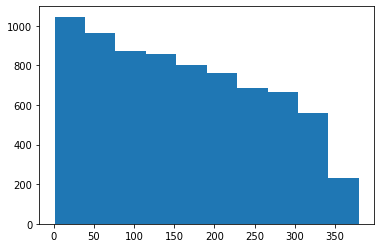

In [14]:
plt.hist(data1_new.fpg_rank)

Given that the ranks max out around 350 and drop off for higher numbers (less age/sex groups have more people in them) I am assuming the above loop worked as intended. 

### Loading in the needed correlation and creating ranks that are correlated

In [15]:
correlation = pd.read_csv('/ihme/homes/lutzes/correlation.csv')
correlation = correlation.drop('Unnamed: 0',axis=1)
old_age = {'age_start': 90, 'age_end': 125, 'sbp_ldl': 0.124353,'sbp_ldl_pval':1.754506e-104,'sbp_bmi':0.005323,'sbp_bmi_pval':9.405201e-01,'ldl_bmi':0.111832,'ldl_bmi_pval':3.384224e-86,'sbp_fpg':0.338096,'sbp_fpg_pval':0,'ldl_fpg':0,'ldl_fpg_pval':'NaN','bmi_fpg':0.294275,'bmi_fpg_pval':0}
correlation = correlation.append(old_age, ignore_index = True)
#correlation

/tmp/ipykernel_1673387/3274002491.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  correlation = correlation.append(old_age, ignore_index = True)


In [16]:
%%capture --no-display
data_all = pd.DataFrame()
#N = 1000 #can change to be the total population size needed 
for i in range(0,len(correlation)):
    age_start = correlation.iloc[i][0]
    age_end = correlation.iloc[i][1]
    sbp_ldl = correlation.iloc[i][2]
    sbp_bmi = correlation.iloc[i][4]
    bmi_ldl = correlation.iloc[i][6]
    sbp_fpg = correlation.iloc[i][8]
    ldl_fpg = correlation.iloc[i][10]
    bmi_fpg = correlation.iloc[i][12]
    N = len(data1.loc[(data1.age > age_start) & (data1.age < age_end)])
    probit_propensity = np.random.multivariate_normal([0,0,0,0], [[1, sbp_ldl, sbp_bmi, sbp_fpg],
                                                         [sbp_ldl, 1, bmi_ldl, ldl_fpg],
                                                         [sbp_bmi, bmi_ldl, 1, bmi_fpg],
                                                             [sbp_fpg, ldl_fpg, bmi_fpg, 1]], size=N)
    propensity = scipy.stats.norm().cdf(probit_propensity)
    data = pd.DataFrame(data = propensity, 
                       columns = ['SBP','LDL','BMI','FPG'])
    data['age_start'] = age_start
    data['age_end'] = age_end
    data_all = data_all.append(data)
data_all = data_all.reset_index()

In [17]:
#Checking that this worked as expected and it does! 
len(data_all), len(data1_new)

(7448, 7448)

In [18]:
data_new = data1_new[['age','sex']]
data_new = data_new.sort_values(by=['age']).reset_index()
data_new = data_new.drop('index',axis=1)
#data_new.head()

In [19]:
data_new = pd.concat([data_new, data_all], axis=1)

In [20]:
data_new['age_group'] = [f'{int(i)}_to_{int(j)}' for (i,j) in zip(data_new.age_start,data_new.age_end)]
data_new.head()

,age,sex,index,SBP,LDL,BMI,FPG,age_start,age_end,age_group
0,25.006635,Female,0,0.383267,0.558469,0.979449,0.318685,25,30,25_to_30
1,25.014514,Male,1,0.907971,0.590774,0.795210,0.426977,25,30,25_to_30
2,25.018104,Male,2,0.392903,0.093566,0.405819,0.218201,25,30,25_to_30
3,25.021147,Male,3,0.698793,0.154805,0.879107,0.319535,25,30,25_to_30
4,25.038105,Male,4,0.773346,0.586043,0.469426,0.091502,25,30,25_to_30


In [21]:
#Just wanted to check that matching in this way worked as I expected and it seems that it did! 
count=0
for i in range(7448):
    if [(data_new.age.iloc[i] > data_new.age_start.iloc[i]) & (data_new.age.iloc[i] > data_new.age_end.iloc[i])]:
        count = count + 1
print(count)

7448


In [22]:
%%capture --no-display
data_final = pd.DataFrame()
for sex in [i for i in list(sex_list)]:
    for age in [j for j in list(data_new.age_group.unique())]: 
        data_current = data_new.loc[(data_new.sex == sex) & (data_new.age_group == age)]
        data_current['bmi_rank'] = data_current.BMI.rank()
        data_current['ldl_rank'] = data_current.LDL.rank()
        data_current['sbp_rank'] = data_current.SBP.rank()
        data_current['fpg_rank'] = data_current.FPG.rank()
        data_final = data_final.append(data_current)
data_final

,age,sex,index,SBP,LDL,BMI,FPG,age_start,age_end,age_group,bmi_rank,ldl_rank,sbp_rank,fpg_rank
0,25.006635,Female,0,0.383267,0.558469,0.979449,0.318685,25,30,25_to_30,364.0,196.0,153.0,111.0
6,25.067368,Female,6,0.931651,0.594421,0.787134,0.852501,25,30,25_to_30,292.0,213.0,350.0,318.0
7,25.076838,Female,7,0.836310,0.147799,0.864566,0.996449,25,30,25_to_30,326.0,62.0,308.0,370.0
8,25.083359,Female,8,0.767812,0.441884,0.972641,0.670282,25,30,25_to_30,362.0,166.0,288.0,245.0
11,25.100092,Female,11,0.921010,0.064820,0.107660,0.365667,25,30,25_to_30,46.0,27.0,345.0,132.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7436,97.466628,Male,52,0.814340,0.334590,0.103419,0.769886,90,125,90_to_125,2.0,7.0,18.0,16.0
7437,97.789606,Male,53,0.423687,0.408413,0.233389,0.275970,90,125,90_to_125,8.0,9.0,11.0,7.0
7441,100.593125,Male,57,0.508278,0.755266,0.596425,0.666883,90,125,90_to_125,16.0,15.0,13.0,14.0
7444,104.731512,Male,60,0.998383,0.875931,0.121960,0.822746,90,125,90_to_125,4.0,18.0,20.0,17.0


### Merging the two dataframes to have the exposures now be correlated

In [23]:
%%capture --no-display
data_final_all = pd.DataFrame()
for sex in [i for i in list(sex_list)]:
    for age in [j for j in list(data_new.age_group.unique())]: 
        data_current_1 = data_final.loc[(data_final.sex == sex) & (data_final.age_group == age)]
        data_current_2 = data1_new.loc[(data1_new.sex == sex) & (data1_new.age_group == age)]
        data_current_1 = data_current_1.sort_values(by=['bmi_rank']).reset_index()
        data_current_2 = data_current_2.sort_values(by=['bmi_rank']).reset_index() 
        data_current_all = pd.concat([data_current_1, data_current_2['bmi_exposure']], axis=1)
        data_final_all = data_final_all.append(data_current_all)

In [24]:
data_final_all = data_final_all.drop(['level_0'],axis=1)
#data_final_all

In [25]:
%%capture --no-display
data_final_all_2 = pd.DataFrame()
for sex in [i for i in list(sex_list)]:
    for age in [j for j in list(data_new.age_group.unique())]: 
        data_current_1 = data_final_all.loc[(data_final_all.sex == sex) & (data_final_all.age_group == age)]
        data_current_2 = data1_new.loc[(data1_new.sex == sex) & (data1_new.age_group == age)]
        data_current_1 = data_current_1.sort_values(by=['ldl_rank']).reset_index()
        data_current_2 = data_current_2.sort_values(by=['ldl_rank']).reset_index() 
        data_current_all = pd.concat([data_current_1, data_current_2['ldl_exposure']], axis=1)
        data_final_all_2 = data_final_all_2.append(data_current_all)

In [26]:
data_final_all_2 = data_final_all_2.drop(['level_0'],axis=1)
#data_final_all_2

In [27]:
%%capture --no-display
data_final_all_3 = pd.DataFrame()
for sex in [i for i in list(sex_list)]:
    for age in [j for j in list(data_new.age_group.unique())]: 
        data_current_1 = data_final_all_2.loc[(data_final_all_2.sex == sex) & (data_final_all_2.age_group == age)]
        data_current_2 = data1_new.loc[(data1_new.sex == sex) & (data1_new.age_group == age)]
        data_current_1 = data_current_1.sort_values(by=['sbp_rank']).reset_index()
        data_current_2 = data_current_2.sort_values(by=['sbp_rank']).reset_index() 
        data_current_all = pd.concat([data_current_1, data_current_2['sbp_exposure']], axis=1)
        data_final_all_3 = data_final_all_3.append(data_current_all)

In [28]:
data_final_all_3 = data_final_all_3.drop(['level_0'],axis=1)
#data_final_all_3

In [29]:
%%capture --no-display
data_final_all_4 = pd.DataFrame()
for sex in [i for i in list(sex_list)]:
    for age in [j for j in list(data_new.age_group.unique())]: 
        data_current_1 = data_final_all_3.loc[(data_final_all_3.sex == sex) & (data_final_all_3.age_group == age)]
        data_current_2 = data1_new.loc[(data1_new.sex == sex) & (data1_new.age_group == age)]
        data_current_1 = data_current_1.sort_values(by=['fpg_rank']).reset_index()
        data_current_2 = data_current_2.sort_values(by=['fpg_rank']).reset_index() 
        data_current_all = pd.concat([data_current_1, data_current_2['fpg_exposure']], axis=1)
        data_final_all_4 = data_final_all_4.append(data_current_all)

In [30]:
data_final_all_4 = data_final_all_4.drop(['level_0'],axis=1)
data_final_all_4

,age,sex,index,SBP,LDL,BMI,FPG,age_start,age_end,age_group,bmi_rank,ldl_rank,sbp_rank,fpg_rank,bmi_exposure,ldl_exposure,sbp_exposure,fpg_exposure
0,25.881932,Female,114,0.057662,0.453095,0.004007,0.004455,25,30,25_to_30,3.0,168.0,23.0,1.0,9.429411,2.754086,99.042498,3.775154
1,29.490539,Female,673,0.256588,0.117548,0.315593,0.005163,25,30,25_to_30,117.0,43.0,109.0,2.0,25.545439,2.023645,106.629601,4.408998
2,26.076544,Female,146,0.331190,0.127804,0.011917,0.006062,25,30,25_to_30,8.0,51.0,137.0,3.0,14.165577,2.053527,108.396129,4.479700
3,29.490579,Female,674,0.039842,0.520667,0.329509,0.007101,25,30,25_to_30,122.0,187.0,16.0,4.0,26.131404,2.842324,97.999401,4.485260
4,28.992407,Female,595,0.634057,0.632907,0.175948,0.011755,25,30,25_to_30,71.0,227.0,230.0,5.0,22.821634,3.053391,112.662971,4.493094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,97.466628,Male,52,0.814340,0.334590,0.103419,0.769886,90,125,90_to_125,2.0,7.0,18.0,16.0,20.862590,1.992292,131.756914,8.924823
16,104.731512,Male,60,0.998383,0.875931,0.121960,0.822746,90,125,90_to_125,4.0,18.0,20.0,17.0,22.603908,3.110143,135.338623,9.188036
17,108.032306,Male,63,0.597551,0.205795,0.518965,0.882975,90,125,90_to_125,13.0,6.0,16.0,18.0,29.913453,1.931030,128.455692,9.404517
18,94.953359,Male,47,0.747006,0.507280,0.181956,0.899996,90,125,90_to_125,7.0,11.0,17.0,19.0,23.602993,2.557536,129.450341,9.781521


### Checking to see that the end exposures are in fact correlated

In [75]:
sbp_bmi, p_val = scipy.stats.spearmanr(data_final_all_4.sbp_exposure, data_final_all_4.fpg_exposure)
sbp_bmi

0.22028257998718467

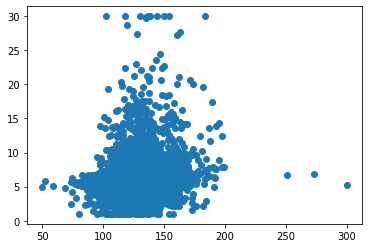

In [74]:
plt.scatter(data_final_all_4.sbp_exposure, data_final_all_4.fpg_exposure)

This seems to be working reasonably well? It is a bit tough to tell for the full dataset since we apply it within a single age/sex group

In [77]:
data_40_female = data_final_all_4.loc[(data_final_all_4.age_group == '40_to_45') & (data_final_all_4.sex == 'Female')]
#data_40_female

In [80]:
sbp_bmi, p_val = scipy.stats.spearmanr(data_40_female.sbp_exposure, data_40_female.bmi_exposure)
sbp_bmi

0.1995048366622463

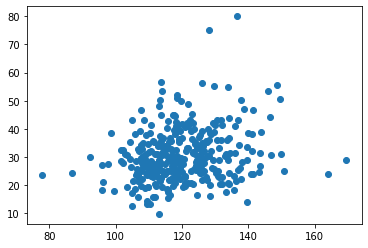

In [81]:
plt.scatter(data_40_female.sbp_exposure, data_40_female.bmi_exposure)

That looks better! 

## Adding in the Relative Risk Values

In [31]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [32]:
#art.keys

In [33]:
sbp_rr = art.load('risk_factor.high_systolic_blood_pressure.relative_risk').reset_index()
sbp_rr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(sbp_rr.age_start,sbp_rr.age_end)]
sbp_rr_mi = sbp_rr.loc[sbp_rr.affected_entity == 'acute_myocardial_infarction']
sbp_rr_mi = sbp_rr_mi.rename(columns={'draw_0':'mi_sbp_rr'})
sbp_rr_stroke = sbp_rr.loc[sbp_rr.affected_entity == 'acute_ischemic_stroke']
sbp_rr_stroke = sbp_rr_stroke.rename(columns={'draw_0':'stroke_sbp_rr'})
#sbp_rr_stroke.head()

In [34]:
bmi_rr = art.load('risk_factor.high_body_mass_index_in_adults.relative_risk').reset_index()
bmi_rr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(bmi_rr.age_start,bmi_rr.age_end)]
bmi_rr_mi = bmi_rr.loc[bmi_rr.affected_entity == 'acute_myocardial_infarction']
bmi_rr_mi = bmi_rr_mi.rename(columns={'draw_0':'mi_bmi_rr'})
bmi_rr_stroke = bmi_rr.loc[bmi_rr.affected_entity == 'acute_ischemic_stroke']
bmi_rr_stroke = bmi_rr_stroke.rename(columns={'draw_0':'stroke_bmi_rr'})
#bmi_rr_stroke.head()

In [35]:
ldl_rr = art.load('risk_factor.high_ldl_cholesterol.relative_risk').reset_index()
ldl_rr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(ldl_rr.age_start,ldl_rr.age_end)]
ldl_rr_mi = ldl_rr.loc[ldl_rr.affected_entity == 'acute_myocardial_infarction']
ldl_rr_mi = ldl_rr_mi.rename(columns={'draw_0':'mi_ldl_rr'})
ldl_rr_stroke = ldl_rr.loc[ldl_rr.affected_entity == 'acute_ischemic_stroke']
ldl_rr_stroke = ldl_rr_stroke.rename(columns={'draw_0':'stroke_ldl_rr'})
#ldl_rr_stroke.head()

In [36]:
fpg_rr = art.load('risk_factor.high_fasting_plasma_glucose.relative_risk').reset_index()
fpg_rr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(fpg_rr.age_start,fpg_rr.age_end)]
fpg_rr_mi = fpg_rr.loc[fpg_rr.affected_entity == 'acute_myocardial_infarction']
fpg_rr_mi = fpg_rr_mi.rename(columns={'draw_0':'mi_fpg_rr'})
fpg_rr_stroke = fpg_rr.loc[fpg_rr.affected_entity == 'acute_ischemic_stroke']
fpg_rr_stroke = fpg_rr_stroke.rename(columns={'draw_0':'stroke_fpg_rr'})
#fpg_rr_stroke.head()

In [37]:
data_working = data_final_all_4.merge(sbp_rr_mi[['sex','age_start','mi_sbp_rr']], on=['sex','age_start'])\
.merge(sbp_rr_stroke[['sex','age_start','stroke_sbp_rr']], on=['sex','age_start'])\
.merge(bmi_rr_mi[['sex','age_start','mi_bmi_rr']], on=['sex','age_start'])\
.merge(bmi_rr_stroke[['sex','age_start','stroke_bmi_rr']], on=['sex','age_start'])\
.merge(ldl_rr_mi[['sex','age_start','mi_ldl_rr']], on=['sex','age_start'])\
.merge(ldl_rr_stroke[['sex','age_start','stroke_ldl_rr']], on=['sex','age_start'])\
.merge(fpg_rr_mi[['sex','age_start','mi_fpg_rr']], on=['sex','age_start'])\
.merge(fpg_rr_stroke[['sex','age_start','stroke_fpg_rr']], on=['sex','age_start'])
#data_working

In [38]:
from typing import List, Tuple, Union
import scipy.stats as sp
def get_lognorm_from_quantiles(median: float, lower: float, upper: float,
                               quantiles: Tuple[float, float] = (0.025, 0.975)) -> sp.lognorm:
    mu = np.log(median)
    stdnorm_quantiles = sp.norm.ppf(quantiles)
    norm_quantiles = np.log([lower, upper])
    sigma = (norm_quantiles[1] - norm_quantiles[0]) / (stdnorm_quantiles[1] - stdnorm_quantiles[0])
    return sp.lognorm(s=sigma, scale=median)

In [39]:
test2 = get_lognorm_from_quantiles(1.14,1.12,1.16).rvs(size=len(data_working))

In [40]:
data_working['hf_bmi_rr'] = test2
data_working.head()

,age,sex,index,SBP,LDL,BMI,FPG,age_start,age_end,age_group,...,fpg_exposure,mi_sbp_rr,stroke_sbp_rr,mi_bmi_rr,stroke_bmi_rr,mi_ldl_rr,stroke_ldl_rr,mi_fpg_rr,stroke_fpg_rr,hf_bmi_rr
0,25.881932,Female,114,0.057662,0.453095,0.004007,0.004455,25,30,25_to_30,...,3.775154,2.0317,1.7644,3.510608,2.405075,2.0053,1.4165,1.9325,1.5236,1.162140
1,29.490539,Female,673,0.256588,0.117548,0.315593,0.005163,25,30,25_to_30,...,4.408998,2.0317,1.7644,3.510608,2.405075,2.0053,1.4165,1.9325,1.5236,1.132736
2,26.076544,Female,146,0.331190,0.127804,0.011917,0.006062,25,30,25_to_30,...,4.479700,2.0317,1.7644,3.510608,2.405075,2.0053,1.4165,1.9325,1.5236,1.129216
3,29.490579,Female,674,0.039842,0.520667,0.329509,0.007101,25,30,25_to_30,...,4.485260,2.0317,1.7644,3.510608,2.405075,2.0053,1.4165,1.9325,1.5236,1.132907
4,28.992407,Female,595,0.634057,0.632907,0.175948,0.011755,25,30,25_to_30,...,4.493094,2.0317,1.7644,3.510608,2.405075,2.0053,1.4165,1.9325,1.5236,1.148039


In [41]:
data_working['hf_sbp_rr'] = np.nan

for i in range(len(data_working)): 
    if data_working.loc[i,'sbp_exposure'] < 120:
        data_working.loc[i,'hf_sbp_rr'] = 1 
    elif data_working.loc[i,'sbp_exposure'] < 130:
        value = get_lognorm_from_quantiles(1.13,1.27,1.43).rvs(size=1)
        data_working.loc[i,'hf_sbp_rr'] = value
    elif data_working.loc[i,'sbp_exposure'] < 140:
        value = get_lognorm_from_quantiles(1.3,1.5,1.73).rvs(size=1)
        data_working.loc[i,'hf_sbp_rr'] = value
    else:
        value = get_lognorm_from_quantiles(1.43,1.76,2.17).rvs(size=1)
        data_working.loc[i,'hf_sbp_rr'] = value

## Adding TMREL

In [42]:
np.random.seed(123)
tmrel_bmi = np.random.uniform(20,25,len(data_working))
tmrel_fpg = np.random.uniform(4.8,5.4,len(data_working))
tmrel_ldl = np.random.uniform(0.7,1.3,len(data_working))
tmrel_sbp = np.random.uniform(110,115,len(data_working))
data_working['TMREL_bmi'] = tmrel_bmi
data_working['TMREL_fpg'] = tmrel_fpg
data_working['TMREL_ldl'] = tmrel_ldl
data_working['TMREL_sbp'] = tmrel_sbp

In [43]:
#data_working

## Mediation 

We need to include the mediation factors to adjust down the RR's for BMI to each of the causes. Since the interactive sim here is for draw 0, I will just be using the draw 0 values. Note that in the future, this could be changed to include more draws.

In [44]:
data_working['mf_bmi_sbp_mi'] = 0.28805035
data_working['mf_bmi_sbp_stroke'] = 0.64581817
data_working['mf_bmi_fpg_mi'] = 0.16869751
data_working['mf_bmi_fpg_stroke'] = 0.19333139
data_working['mf_bmi_ldl_mi'] = 0.08831674
data_working['mf_bmi_ldl_stroke'] = 0.05147814
data_working['mf_fpg_ldl_mi'] = 0.03121209
data_working['mf_fpg_ldl_stroke'] = 0.04052352
data_working['mf_bmi_sbp_hf'] = 0.17752491443993446

data_working.head()

,age,sex,index,SBP,LDL,BMI,FPG,age_start,age_end,age_group,...,TMREL_sbp,mf_bmi_sbp_mi,mf_bmi_sbp_stroke,mf_bmi_fpg_mi,mf_bmi_fpg_stroke,mf_bmi_ldl_mi,mf_bmi_ldl_stroke,mf_fpg_ldl_mi,mf_fpg_ldl_stroke,mf_bmi_sbp_hf
0,25.881932,Female,114,0.057662,0.453095,0.004007,0.004455,25,30,25_to_30,...,112.206082,0.28805,0.645818,0.168698,0.193331,0.088317,0.051478,0.031212,0.040524,0.177525
1,29.490539,Female,673,0.256588,0.117548,0.315593,0.005163,25,30,25_to_30,...,111.193066,0.28805,0.645818,0.168698,0.193331,0.088317,0.051478,0.031212,0.040524,0.177525
2,26.076544,Female,146,0.331190,0.127804,0.011917,0.006062,25,30,25_to_30,...,110.140281,0.28805,0.645818,0.168698,0.193331,0.088317,0.051478,0.031212,0.040524,0.177525
3,29.490579,Female,674,0.039842,0.520667,0.329509,0.007101,25,30,25_to_30,...,111.468976,0.28805,0.645818,0.168698,0.193331,0.088317,0.051478,0.031212,0.040524,0.177525
4,28.992407,Female,595,0.634057,0.632907,0.175948,0.011755,25,30,25_to_30,...,113.489130,0.28805,0.645818,0.168698,0.193331,0.088317,0.051478,0.031212,0.040524,0.177525


In [45]:
data_working['mi_bmi_rr_adjusted'] = 1 + (data_working['mi_bmi_rr'] - 1) * ((1- data_working['mf_bmi_sbp_mi'])*(1- data_working['mf_bmi_fpg_mi'])*(1- data_working['mf_bmi_ldl_mi']))
data_working['stroke_bmi_rr_adjusted'] = 1 + (data_working['stroke_bmi_rr'] - 1) * ((1- data_working['mf_bmi_sbp_stroke'])*(1- data_working['mf_bmi_fpg_stroke'])*(1- data_working['mf_bmi_ldl_stroke']))
data_working['hf_bmi_rr_adjusted'] = 1 + (data_working['hf_bmi_rr'] - 1) * ((1- data_working['mf_bmi_sbp_hf']))
data_working['mi_fpg_rr_adjusted'] = 1 + (data_working['mi_fpg_rr'] - 1) * ((1- data_working['mf_fpg_ldl_mi']))
data_working['stroke_fpg_rr_adjusted'] = 1 + (data_working['stroke_fpg_rr'] - 1) * ((1- data_working['mf_fpg_ldl_stroke']))
data_working.head()

,age,sex,index,SBP,LDL,BMI,FPG,age_start,age_end,age_group,...,mf_bmi_ldl_mi,mf_bmi_ldl_stroke,mf_fpg_ldl_mi,mf_fpg_ldl_stroke,mf_bmi_sbp_hf,mi_bmi_rr_adjusted,stroke_bmi_rr_adjusted,hf_bmi_rr_adjusted,mi_fpg_rr_adjusted,stroke_fpg_rr_adjusted
0,25.881932,Female,114,0.057662,0.453095,0.004007,0.004455,25,30,25_to_30,...,0.088317,0.051478,0.031212,0.040524,0.177525,2.354663,1.380775,1.133356,1.903395,1.502382
1,29.490539,Female,673,0.256588,0.117548,0.315593,0.005163,25,30,25_to_30,...,0.088317,0.051478,0.031212,0.040524,0.177525,2.354663,1.380775,1.109172,1.903395,1.502382
2,26.076544,Female,146,0.331190,0.127804,0.011917,0.006062,25,30,25_to_30,...,0.088317,0.051478,0.031212,0.040524,0.177525,2.354663,1.380775,1.106277,1.903395,1.502382
3,29.490579,Female,674,0.039842,0.520667,0.329509,0.007101,25,30,25_to_30,...,0.088317,0.051478,0.031212,0.040524,0.177525,2.354663,1.380775,1.109312,1.903395,1.502382
4,28.992407,Female,595,0.634057,0.632907,0.175948,0.011755,25,30,25_to_30,...,0.088317,0.051478,0.031212,0.040524,0.177525,2.354663,1.380775,1.121758,1.903395,1.502382


### Find the Sim Level RRs, and Joint RRs for Each Cause

In [46]:
%%capture --no-display
data_working['bmi_exposure_truncated'] = np.nan
for i in range(len(data_working)):
    data_working['bmi_exposure_truncated'].iloc[i] = min([data_working['bmi_exposure'].iloc[i],40.8])
#data_working

In [64]:
%%capture --no-display
data_working['bmi_mi_rr_sim'] = np.nan
data_working['bmi_stroke_rr_sim'] = np.nan
data_working['bmi_hf_rr_sim'] = np.nan
data_working['sbp_mi_rr_sim'] = np.nan
data_working['sbp_stroke_rr_sim'] = np.nan
data_working['sbp_hf_rr_sim'] = np.nan
data_working['fpg_mi_rr_sim'] = np.nan
data_working['fpg_stroke_rr_sim'] = np.nan
data_working['ldl_mi_rr_sim'] = np.nan
data_working['ldl_stroke_rr_sim'] = np.nan
for i in range(len(data_working)):
    data_working['bmi_mi_rr_sim'].iloc[i] = data_working['mi_bmi_rr_adjusted'].iloc[i]**[max((data_working['bmi_exposure'].iloc[i] - data_working['TMREL_bmi'].iloc[i]),0)/5]
    data_working['bmi_stroke_rr_sim'].iloc[i] = data_working['stroke_bmi_rr_adjusted'].iloc[i]**[max((data_working['bmi_exposure'].iloc[i] - data_working['TMREL_bmi'].iloc[i]),0)/5]
    data_working['bmi_hf_rr_sim'].iloc[i] = data_working['hf_bmi_rr_adjusted'].iloc[i]**[max((data_working['bmi_exposure_truncated'].iloc[i] - data_working['TMREL_bmi'].iloc[i]),0)]
    data_working['sbp_mi_rr_sim'].iloc[i] = data_working['mi_sbp_rr'].iloc[i]**[max((data_working['sbp_exposure'].iloc[i] - data_working['TMREL_sbp'].iloc[i]),0)/10]
    data_working['sbp_stroke_rr_sim'].iloc[i] = data_working['stroke_sbp_rr'].iloc[i]**[max((data_working['sbp_exposure'].iloc[i] - data_working['TMREL_sbp'].iloc[i]),0)/10]
    data_working['sbp_hf_rr_sim'].iloc[i] = data_working['hf_sbp_rr'].iloc[i]
    data_working['fpg_mi_rr_sim'].iloc[i] = data_working['mi_fpg_rr_adjusted'].iloc[i]**[max((data_working['fpg_exposure'].iloc[i] - data_working['TMREL_fpg'].iloc[i]),0)]
    data_working['fpg_stroke_rr_sim'].iloc[i] = data_working['stroke_fpg_rr_adjusted'].iloc[i]**[max((data_working['fpg_exposure'].iloc[i] - data_working['TMREL_fpg'].iloc[i]),0)]
    data_working['ldl_mi_rr_sim'].iloc[i] = data_working['mi_ldl_rr'].iloc[i]**[max((data_working['ldl_exposure'].iloc[i] - data_working['TMREL_ldl'].iloc[i]),0)]
    data_working['ldl_stroke_rr_sim'].iloc[i] = data_working['stroke_ldl_rr'].iloc[i]**[max((data_working['ldl_exposure'].iloc[i] - data_working['TMREL_ldl'].iloc[i]),0)]
#data_working

In [65]:
data_working['mi_rr_combo'] = data_working['bmi_mi_rr_sim'] * data_working['sbp_mi_rr_sim'] * data_working['fpg_mi_rr_sim'] * data_working['ldl_mi_rr_sim']
data_working['stroke_rr_combo'] = data_working['bmi_stroke_rr_sim'] * data_working['sbp_stroke_rr_sim'] * data_working['fpg_stroke_rr_sim'] * data_working['ldl_stroke_rr_sim']
data_working['hf_rr_combo'] = data_working['bmi_hf_rr_sim'] * data_working['sbp_hf_rr_sim']
#data_working

### To PAFs!

In [68]:
data_grouped = data_working.groupby(['sex', 'age_group']).agg({'mi_rr_combo':['mean'], 
                                                              'stroke_rr_combo':['mean'],
                                                              'hf_rr_combo':['mean'],})

#data_grouped = data_working.groupby(['sex', 'age_group']).mi_rr_combo.describe().filter(['mean','std']).stroke_rr_combo.describe().filter(['mean','std']).hf_rr_combo.describe().filter(['mean','std']).reset_index()
data_grouped

mi_rr_combo stroke_rr_combo hf_rr_combo
                         mean            mean        mean
sex    age_group                                         
Female 25_to_30   2755.307334       19.812710    3.328042
       30_to_35    103.865845       11.052161    3.886441
       35_to_40     21.483503        6.911258    3.381989
       40_to_45     22.432467        7.333077    3.388337
       45_to_50     24.667628        9.113377    3.965384
       50_to_55     19.478402        9.620646    3.955868
       55_to_60     10.043248        4.520629    3.520025
       60_to_65     16.250206        9.250928    4.294820
       65_to_70      8.465748        6.282813    3.501008
       70_to_75      7.487912        5.923216    3.909804
       75_to_80     11.843917        6.526673    3.536865
       80_to_85     29.885882        4.795893    3.908256
       85_to_90      6.200883        3.182351    3.916831
       90_to_125     6.384117        3.063539    3.484459
Male   25_to_30    202.588635        6.996214    2.828598
       30_to_35     83.270003       12.131867    3.417103
       35_to_40    182.029958       51.047010    3.472562
       40_to_45    335.688851      115.766071    3.680684
       45_to_50     35.821009       10.999949    4.309384
       50_to_55     41.901236       15.392011    3.666113
       55_to_60     22.020270       10.047063    3.191261
       60_to_65     11.996522        7.197395    3.544692
       65_to_70      6.262982        4.032036    3.459176
       70_to_75      5.884540        4.181304    3.340266
       75_to_80      3.809018        2.741506    2.699253
       80_to_85      4.682634        2.556102    2.528141
       85_to_90      9.185582        3.351938    2.771240
       90_to_125     4.126957        2.198257    2.340850

In [69]:
data_grouped['PAF_mi'] = (data_grouped['mi_rr_combo'] - 1) / data_grouped['mi_rr_combo']
data_grouped['PAF_stroke'] = (data_grouped['stroke_rr_combo'] - 1) / data_grouped['stroke_rr_combo']
data_grouped['PAF_hf'] = (data_grouped['hf_rr_combo'] - 1) / data_grouped['hf_rr_combo']
data_grouped

mi_rr_combo stroke_rr_combo hf_rr_combo    PAF_mi  \
                         mean            mean        mean             
sex    age_group                                                      
Female 25_to_30   2755.307334       19.812710    3.328042  0.999637   
       30_to_35    103.865845       11.052161    3.886441  0.990372   
       35_to_40     21.483503        6.911258    3.381989  0.953453   
       40_to_45     22.432467        7.333077    3.388337  0.955422   
       45_to_50     24.667628        9.113377    3.965384  0.959461   
       50_to_55     19.478402        9.620646    3.955868  0.948661   
       55_to_60     10.043248        4.520629    3.520025  0.900431   
       60_to_65     16.250206        9.250928    4.294820  0.938462   
       65_to_70      8.465748        6.282813    3.501008  0.881877   
       70_to_75      7.487912        5.923216    3.909804  0.866451   
       75_to_80     11.843917        6.526673    3.536865  0.915568   
       80_to_85     29.885882        4.795893    3.908256  0.966539   
       85_to_90      6.200883        3.182351    3.916831  0.838733   
       90_to_125     6.384117        3.063539    3.484459  0.843361   
Male   25_to_30    202.588635        6.996214    2.828598  0.995064   
       30_to_35     83.270003       12.131867    3.417103  0.987991   
       35_to_40    182.029958       51.047010    3.472562  0.994506   
       40_to_45    335.688851      115.766071    3.680684  0.997021   
       45_to_50     35.821009       10.999949    4.309384  0.972083   
       50_to_55     41.901236       15.392011    3.666113  0.976134   
       55_to_60     22.020270       10.047063    3.191261  0.954587   
       60_to_65     11.996522        7.197395    3.544692  0.916643   
       65_to_70      6.262982        4.032036    3.459176  0.840332   
       70_to_75      5.884540        4.181304    3.340266  0.830063   
       75_to_80      3.809018        2.741506    2.699253  0.737465   
       80_to_85      4.682634        2.556102    2.528141  0.786445   
       85_to_90      9.185582        3.351938    2.771240  0.891134   
       90_to_125     4.126957        2.198257    2.340850  0.757691   

                 PAF_stroke    PAF_hf  
                                       
sex    age_group                       
Female 25_to_30    0.949527  0.699523  
       30_to_35    0.909520  0.742695  
       35_to_40    0.855309  0.704316  
       40_to_45    0.863632  0.704870  
       45_to_50    0.890271  0.747818  
       50_to_55    0.896057  0.747211  
       55_to_60    0.778792  0.715911  
       60_to_65    0.891903  0.767161  
       65_to_70    0.840836  0.714368  
       70_to_75    0.831173  0.744233  
       75_to_80    0.846783  0.717264  
       80_to_85    0.791488  0.744131  
       85_to_90    0.685767  0.744692  
       90_to_125   0.673580  0.713011  
Male   25_to_30    0.857066  0.646468  
       30_to_35    0.917572  0.707354  
       35_to_40    0.980410  0.712028  
       40_to_45    0.991362  0.728311  
       45_to_50    0.909090  0.767948  
       50_to_55    0.935031  0.727232  
       55_to_60    0.900468  0.686644  
       60_to_65    0.861061  0.717888  
       65_to_70    0.751986  0.710914  
       70_to_75    0.760840  0.700623  
       75_to_80    0.635237  0.629527  
       80_to_85    0.608779  0.604452  
       85_to_90    0.701665  0.639151  
       90_to_125   0.545094  0.572805

All done :) 